In [1]:
# import dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as st

# import linregress method from scipy module
from scipy.stats import linregress

In [2]:
# create variable to reference csv file to read to notebook
data = "Resources/cleaned_used_car_data.csv"

In [3]:
# read csv file into Pandas DataFrame
df_raw = pd.read_csv(data)

In [4]:
# preview DataFrame
df_raw

,Unnamed: 0,ID,pricesold,yearsold,zipcode,Mileage,Make,Model,Year,Trim,Engine,BodyType,NumCylinders,DriveType
0,2,119660,8750,2020,33449,55000,Jaguar,XJS,1995,2+2 Cabriolet,4.0L In-Line 6 Cylinder,Convertible,6,RWD
1,3,80773,11600,2019,7852,97200,Ford,Mustang,1968,Stock,289 cu. in. V8,Coupe,8,RWD
2,4,64287,44000,2019,7728,40703,Porsche,911,2002,Turbo X-50,3.6L,Coupe,6,AWD
3,7,5250,70000,2019,7627,6500,Land Rover,Defender,1997,NaN,4.0 Liter Fuel Injected V8,NaN,0,4WD
4,8,29023,1330,2019,7043,167000,Honda,Civic,2001,EX,NaN,Coupe,4,FWD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68955,122139,14948,4200,2019,80233,102700,Ford,Mustang,1977,NaN,302,Fastback,8,NaN
68956,122140,58814,6500,2019,53132,128000,Ford,E-Series Van,2012,NaN,E-150,NaN,0,NaN
68957,122141,2156,2000,2019,77536,50000,Ford,Bronco,1978,NaN,351m,NaN,8,4WD
68958,122142,29096,2280,2019,92131,164337,BMW,3-Series,2000,328ci,M52TU 2.8L,Coupe,6,RWD


In [5]:
# create copy of DataFrame with columns selected columns
df_analysis = df_raw[["ID", "pricesold", "yearsold", "zipcode", "Mileage", "Make", "Model", "Year","NumCylinders"]]

In [6]:
df_analysis.dtypes

ID               int64
pricesold        int64
yearsold         int64
zipcode          int64
Mileage          int64
Make            object
Model           object
Year             int64
NumCylinders     int64
dtype: object

In [7]:
# exclude cars where year is not realisitic -- save to separate DataFrame
df_yr_exclude = pd.DataFrame(df_analysis.loc[(df_analysis["Year"] < 1950),:])
df_yr_exclude

,ID,pricesold,yearsold,zipcode,Mileage,Make,Model,Year,NumCylinders
25,9704,17000,2019,72223,0,Dodge,Other,1936,0
30,50079,16450,2019,59806,4327,Ford,TUDOR,1946,8
38,19071,15000,2019,90260,6756,Ford,Model A,1931,4
39,96419,22770,2019,5733,31008,Ford,Wagon,1949,8
62,91901,8200,2019,4284,50000,Cadillac,Other,1937,8
...,...,...,...,...,...,...,...,...,...
68867,93619,17340,2020,48038,12345,Ford,Other Pickups,1940,0
68879,67000,20000,2019,47006,500,Ford,Model A,1930,8
68929,62630,31270,2019,23487,15000,Ford,Coupe,1934,8
68930,41523,13600,2019,23487,1200,Ford,Other,1923,8


In [8]:
# exclude cars where mileage is 0 -- save to separate DataFrame
df_0_miles = pd.DataFrame(df_analysis.loc[(df_analysis["Mileage"] == 0),:]) 
df_0_miles

,ID,pricesold,yearsold,zipcode,Mileage,Make,Model,Year,NumCylinders
25,9704,17000,2019,72223,0,Dodge,Other,1936,0
50,58533,9600,2019,49068,0,Dodge,Dart,1973,8
105,9643,3750,2019,85014,0,Chevrolet,Other Pickups,1966,8
108,90857,4500,2019,85326,0,Chevrolet,Camaro,1971,0
137,34684,1280,2019,72601,0,Jeep,CJ,1948,4
...,...,...,...,...,...,...,...,...,...
68673,3728,9000,2019,98277,0,Ford,Mustang,1993,8
68781,83880,8950,2019,37866,0,Ford,Bronco,1971,0
68827,89930,16060,2019,80517,0,Dodge,Power Wagon,1947,6
68829,69214,11010,2019,83651,0,Ford,F-100,1956,8


In [9]:
# create DataFrame that excludes cars with 0 year or 0 miles
df_analysis_filtered = pd.DataFrame(df_analysis.loc[(df_analysis["Year"] >= 1950) & (df_analysis["Mileage"] != 0),])
df_analysis_filtered

,ID,pricesold,yearsold,zipcode,Mileage,Make,Model,Year,NumCylinders
0,119660,8750,2020,33449,55000,Jaguar,XJS,1995,6
1,80773,11600,2019,7852,97200,Ford,Mustang,1968,8
2,64287,44000,2019,7728,40703,Porsche,911,2002,6
3,5250,70000,2019,7627,6500,Land Rover,Defender,1997,0
4,29023,1330,2019,7043,167000,Honda,Civic,2001,4
...,...,...,...,...,...,...,...,...,...
68955,14948,4200,2019,80233,102700,Ford,Mustang,1977,8
68956,58814,6500,2019,53132,128000,Ford,E-Series Van,2012,0
68957,2156,2000,2019,77536,50000,Ford,Bronco,1978,8
68958,29096,2280,2019,92131,164337,BMW,3-Series,2000,6


In [10]:
df_update_age = df_analysis_filtered.copy()
df_update_age

,ID,pricesold,yearsold,zipcode,Mileage,Make,Model,Year,NumCylinders
0,119660,8750,2020,33449,55000,Jaguar,XJS,1995,6
1,80773,11600,2019,7852,97200,Ford,Mustang,1968,8
2,64287,44000,2019,7728,40703,Porsche,911,2002,6
3,5250,70000,2019,7627,6500,Land Rover,Defender,1997,0
4,29023,1330,2019,7043,167000,Honda,Civic,2001,4
...,...,...,...,...,...,...,...,...,...
68955,14948,4200,2019,80233,102700,Ford,Mustang,1977,8
68956,58814,6500,2019,53132,128000,Ford,E-Series Van,2012,0
68957,2156,2000,2019,77536,50000,Ford,Bronco,1978,8
68958,29096,2280,2019,92131,164337,BMW,3-Series,2000,6


In [11]:
# calculate age of the car (yearsold - year) & store in variable "CarAge"
CarAge = df_update_age["yearsold"] - df_update_age["Year"]

# add new column to DataFrame -- yearsold - Year
df_update_age["CarAge"] = CarAge

# preview DataFrame with new column
df_update_age.head()

,ID,pricesold,yearsold,zipcode,Mileage,Make,Model,Year,NumCylinders,CarAge
0,119660,8750,2020,33449,55000,Jaguar,XJS,1995,6,25
1,80773,11600,2019,7852,97200,Ford,Mustang,1968,8,51
2,64287,44000,2019,7728,40703,Porsche,911,2002,6,17
3,5250,70000,2019,7627,6500,Land Rover,Defender,1997,0,22
4,29023,1330,2019,7043,167000,Honda,Civic,2001,4,18


In [12]:
df_ages_to_fix = pd.DataFrame(df_update_age.loc[(df_update_age["CarAge"] < 0),:])
df_ages_to_fix

,ID,pricesold,yearsold,zipcode,Mileage,Make,Model,Year,NumCylinders,CarAge
2103,84970,13900,2019,40214,41819,Chevrolet,Corvette,2020,8,-1
3025,82310,13000,2019,44224,10307,Toyota,Corolla,2020,4,-1
10691,85641,65100,2019,12538,25,Toyota,Supra,2020,0,-1
10692,54050,63300,2019,12538,50,Toyota,Supra,2020,6,-1
10693,85952,62200,2019,12538,15,Toyota,Supra,2020,6,-1
17527,72236,19450,2019,48228,279,Chevrolet,Malibu,2020,0,-1
23467,96951,9000,2019,17820,3500,Toyota,Corolla,2020,4,-1
25021,73043,19190,2019,18966,14,Nissan,Altima,2020,4,-1
25241,62000,69900,2019,28787,18,Toyota,Supra,2020,6,-1
29362,95331,95300,2019,81006,50,Ford,Mustang,2020,8,-1


In [13]:
#replace CarAge -1 with 0
df_update_age.at[2103,"CarAge"] = 0
df_update_age.at[3025,"CarAge"] = 0
df_update_age.at[10691,"CarAge"] = 0
df_update_age.at[10692,"CarAge"] = 0
df_update_age.at[10693,"CarAge"] = 0
df_update_age.at[17527,"CarAge"] = 0
df_update_age.at[23467,"CarAge"] = 0
df_update_age.at[25021,"CarAge"] = 0
df_update_age.at[25241,"CarAge"] = 0
df_update_age.at[29362,"CarAge"] = 0
df_update_age.at[41331,"CarAge"] = 0
df_update_age.at[47327,"CarAge"] = 0
df_update_age.at[56819,"CarAge"] = 0

#update Year for 2914 to 2014
df_update_age.at[56622,"CarAge"]=5

In [14]:
# calculate age of the car (yearsold - year) & store in variable "CarAge"
OriginalCarAge = df_update_age["yearsold"] - df_update_age["Year"]

# add new column to DataFrame -- yearsold - Year
df_update_age["OriginalCarAge"] = OriginalCarAge 

# preview DataFrame with new column
df_update_age.head()

,ID,pricesold,yearsold,zipcode,Mileage,Make,Model,Year,NumCylinders,CarAge,OriginalCarAge
0,119660,8750,2020,33449,55000,Jaguar,XJS,1995,6,25,25
1,80773,11600,2019,7852,97200,Ford,Mustang,1968,8,51,51
2,64287,44000,2019,7728,40703,Porsche,911,2002,6,17,17
3,5250,70000,2019,7627,6500,Land Rover,Defender,1997,0,22,22
4,29023,1330,2019,7043,167000,Honda,Civic,2001,4,18,18


In [15]:
# add revised car age to df_analysis_filtered
df_analysis_filtered["CarAge"] = df_update_age["CarAge"]
df_analysis_filtered["OriginalCarAge"] = df_update_age["OriginalCarAge"]

df_analysis_filtered.head()

,ID,pricesold,yearsold,zipcode,Mileage,Make,Model,Year,NumCylinders,CarAge,OriginalCarAge
0,119660,8750,2020,33449,55000,Jaguar,XJS,1995,6,25,25
1,80773,11600,2019,7852,97200,Ford,Mustang,1968,8,51,51
2,64287,44000,2019,7728,40703,Porsche,911,2002,6,17,17
3,5250,70000,2019,7627,6500,Land Rover,Defender,1997,0,22,22
4,29023,1330,2019,7043,167000,Honda,Civic,2001,4,18,18


In [16]:
check = pd.DataFrame(df_analysis_filtered.loc[(df_analysis_filtered["OriginalCarAge"] < 0),:])
check

,ID,pricesold,yearsold,zipcode,Mileage,Make,Model,Year,NumCylinders,CarAge,OriginalCarAge
2103,84970,13900,2019,40214,41819,Chevrolet,Corvette,2020,8,0,-1
3025,82310,13000,2019,44224,10307,Toyota,Corolla,2020,4,0,-1
10691,85641,65100,2019,12538,25,Toyota,Supra,2020,0,0,-1
10692,54050,63300,2019,12538,50,Toyota,Supra,2020,6,0,-1
10693,85952,62200,2019,12538,15,Toyota,Supra,2020,6,0,-1
17527,72236,19450,2019,48228,279,Chevrolet,Malibu,2020,0,0,-1
23467,96951,9000,2019,17820,3500,Toyota,Corolla,2020,4,0,-1
25021,73043,19190,2019,18966,14,Nissan,Altima,2020,4,0,-1
25241,62000,69900,2019,28787,18,Toyota,Supra,2020,6,0,-1
29362,95331,95300,2019,81006,50,Ford,Mustang,2020,8,0,-1


In [17]:
# create dataframes for each car make
df_audi = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == "Audi",:])
df_bmw = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == "BMW",:])
df_buick = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == "Buick",:])

df_cadillac = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == "Cadillac",:])
df_chevrolet = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == "Chevrolet",:])
df_chrysler = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == "Chrysler",:])

df_dodge = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == "Dodge",:])
df_ford = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == "Ford",:])
df_gmc = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == "GMC",:])

df_honda = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == "Honda",:])
df_jaguar = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == "Jaguar",:])
df_jeep = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == "Jeep",:])

df_landrover = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == "Land Rover",:])
df_lexus = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == "Lexus",:])
df_lincoln = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == "Lincoln",:])

df_mercedes = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == "Mercedes-Benz",:])
df_nissan = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == "Nissan",:])
df_pontiac = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == "Pontiac",:])

df_porsche = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == "Porsche",:])
df_subaru = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == "Subaru",:])
df_toyota = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == "Toyota",:])
df_vw = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == "Volkswagen",:])

In [18]:
# Define a function to create Linear Regression plots
def plot_lin_regress(x, y, x_label, y_label, label_regression): 
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
    
  # generate regression values
    regress_values = x * slope + intercept
    
  # create string to display regression equation
    line_eq =  "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

    plt.figure(figsize = (12,6))
    
  # generate scatterplot
    plt.scatter(x, y, edgecolor = "k", marker = 'o')

  # add line for linear regression
    plt.plot(x, regress_values, "r-")
    
  # add axis labels
    plt.xlabel(x_label, fontsize = 10)
    plt.ylabel(y_label, fontsize = 10) 

    # add linear regression annotations
    plt.annotate(line_eq, label_regression, fontsize = 10, color = "red")

  # print r-squared value
    print(f"the r-squared value is: {rvalue**2}")
    
  # print correlation coefficient (pearson r)
    correlation = st.pearsonr(x,y)
    print(f"the correlation between factors plotted in the graph is {round(correlation[0],2)}")

the r-squared value is: 0.19708461469885624
the correlation between factors plotted in the graph is -0.44


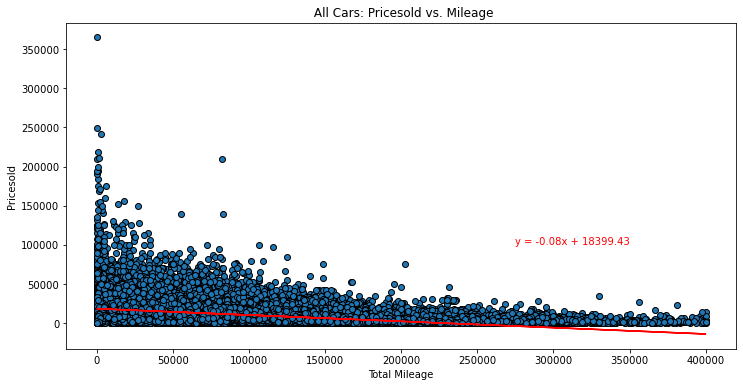

In [19]:
# Plot overall price vs. mileage, for all brands

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_analysis_filtered["Mileage"]
y = df_analysis_filtered["pricesold"]
x_label = "Total Mileage"
y_label = "Pricesold"
label_regression = (275000,100000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f" All Cars: Pricesold vs. Mileage")

# # save image
plt.savefig("Graphs-Analysis/Price_vs_Mileage.png")

# display graph
plt.show()

the r-squared value is: 0.0013458817479851894
the correlation between factors plotted in the graph is -0.04


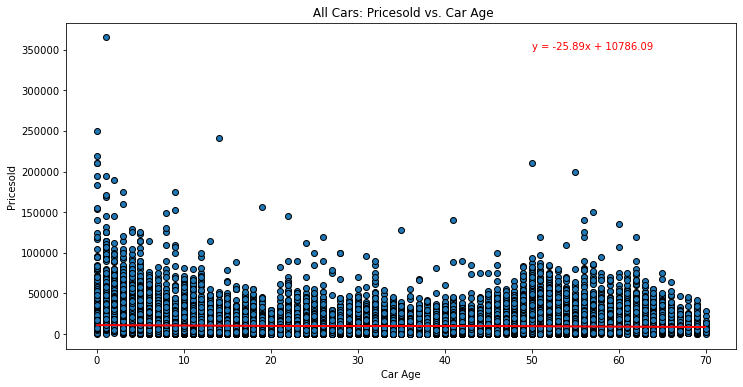

In [20]:
# Plot overall price vs. age, for all brands

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_analysis_filtered["CarAge"]
y = df_analysis_filtered["pricesold"]
x_label = "Car Age"
y_label = "Pricesold"
label_regression = (50,350000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f" All Cars: Pricesold vs. Car Age")

# # save image
plt.savefig("Graphs-Analysis/Price_vs_Age.png")

# display graph
plt.show()

the r-squared value is: 0.3302524244562322
the correlation between factors plotted in the graph is -0.57


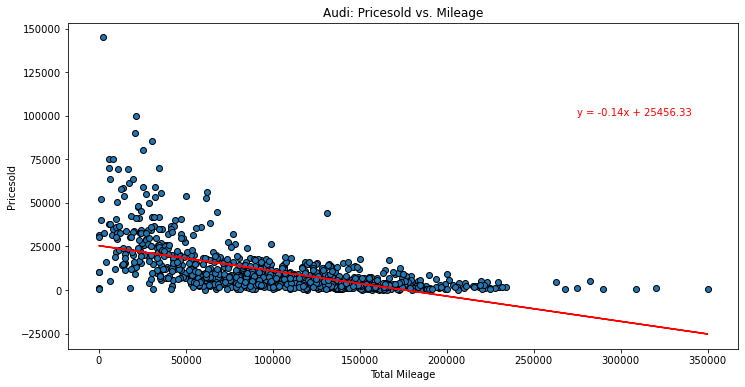

In [21]:
brand = "Audi"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["Mileage"]
y = df_regression["pricesold"]
x_label = "Total Mileage"
y_label = "Pricesold"
label_regression = (275000,100000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. Mileage")

# save image
plt.savefig("Graphs-Analysis/Audi-Price_vs_Mileage.png")

# display graph
plt.show()

the r-squared value is: 0.25303470616063967
the correlation between factors plotted in the graph is -0.5


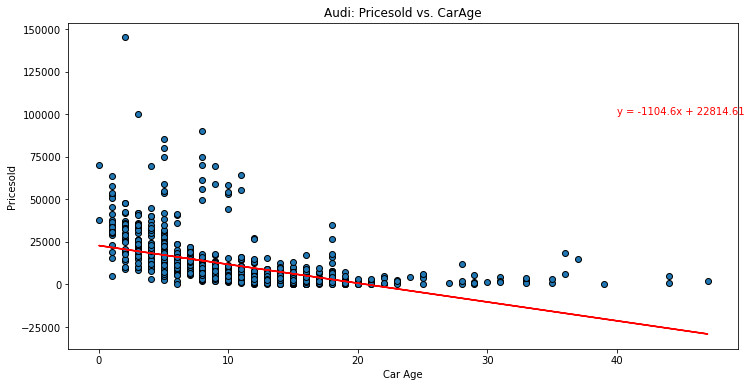

In [22]:
brand = "Audi"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["CarAge"]
y = df_regression["pricesold"]
x_label = "Car Age"
y_label = "Pricesold"
label_regression = (40,100000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. CarAge")

# save image
plt.savefig("Graphs-Analysis/Audi-Price_vs_Age.png")

# display graph
plt.show()

the r-squared value is: 0.3071733414517728
the correlation between factors plotted in the graph is -0.55


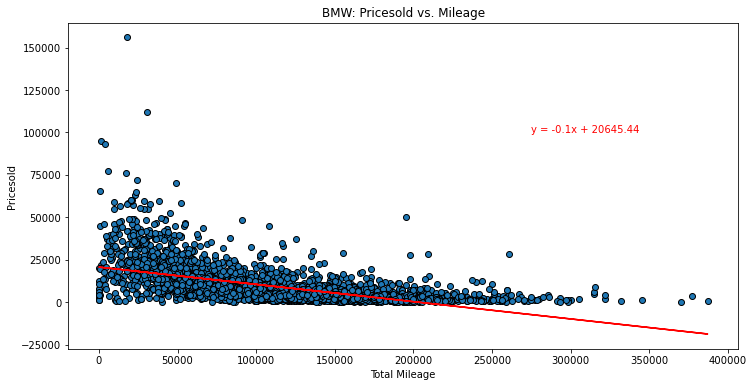

In [23]:
brand = "BMW"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["Mileage"]
y = df_regression["pricesold"]
x_label = "Total Mileage"
y_label = "Pricesold"
label_regression = (275000,100000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. Mileage")

# save image
plt.savefig("Graphs-Analysis/BMW-Price_vs_Mileage.png")

# display graph
plt.show()

the r-squared value is: 0.1249645350171096
the correlation between factors plotted in the graph is -0.35


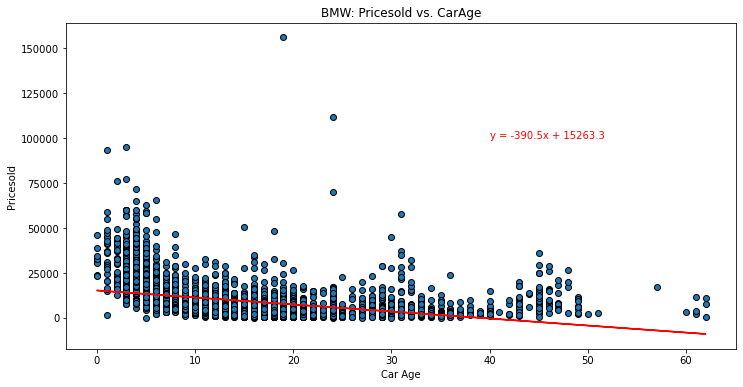

In [24]:
brand = "BMW"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["CarAge"]
y = df_regression["pricesold"]
x_label = "Car Age"
y_label = "Pricesold"
label_regression = (40,100000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. CarAge")

# save image
plt.savefig("Graphs-Analysis/BMW-Price_vs_Age.png")

# display graph
plt.show()

the r-squared value is: 0.22849665299046953
the correlation between factors plotted in the graph is -0.48


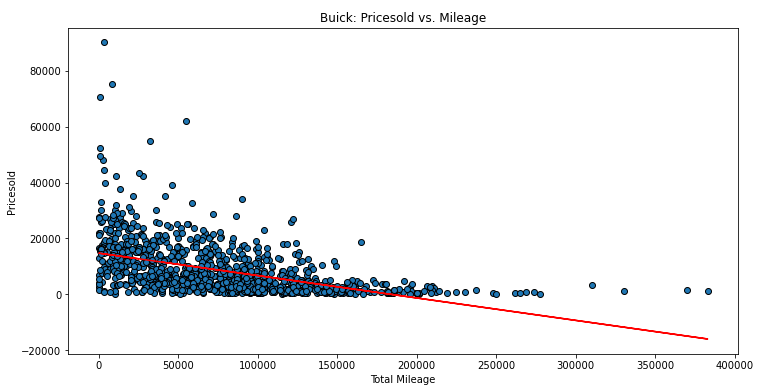

In [25]:
brand = "Buick"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["Mileage"]
y = df_regression["pricesold"]
x_label = "Total Mileage"
y_label = "Pricesold"
label_regression = (275000,100000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. Mileage")

# save image
plt.savefig("Graphs-Analysis/Buick-Price_vs_Mileage.png")

# display graph
plt.show()

the r-squared value is: 0.0009100030248659784
the correlation between factors plotted in the graph is -0.03


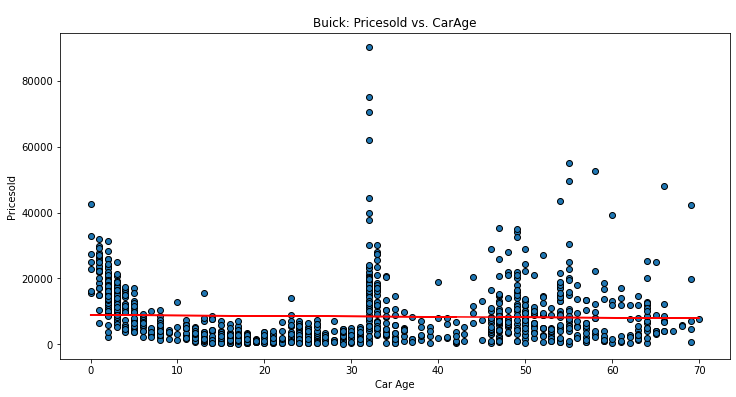

In [26]:
brand = "Buick"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["CarAge"]
y = df_regression["pricesold"]
x_label = "Car Age"
y_label = "Pricesold"
label_regression = (40,100000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. CarAge")

# save image
plt.savefig("Graphs-Analysis/Buick-Price_vs_Age.png")

# display graph
plt.show()

the r-squared value is: 0.18793873765917915
the correlation between factors plotted in the graph is -0.43


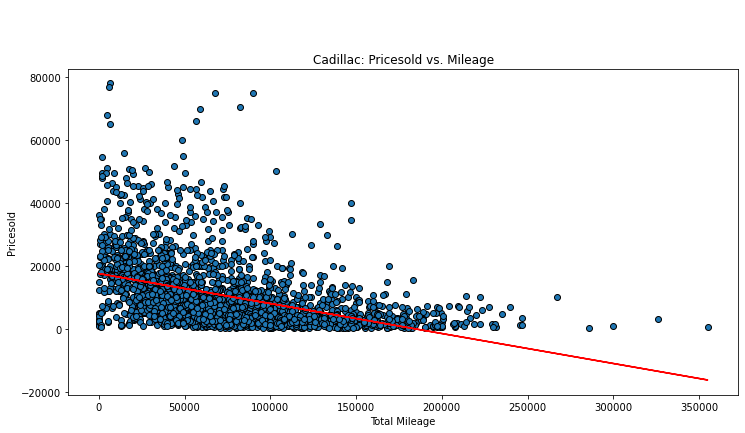

In [27]:
brand = "Cadillac"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["Mileage"]
y = df_regression["pricesold"]
x_label = "Total Mileage"
y_label = "Pricesold"
label_regression = (275000,100000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. Mileage")

# save image
plt.savefig("Graphs-Analysis/Cadillac-Price_vs_Mileage.png")

# display graph
plt.show()

the r-squared value is: 0.05228676885643168
the correlation between factors plotted in the graph is -0.23


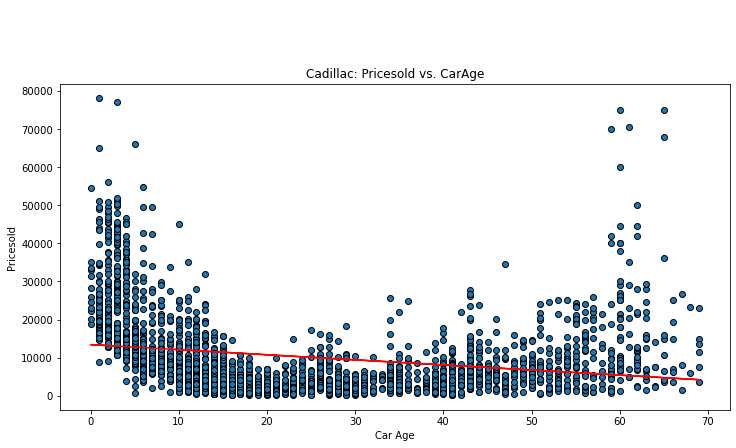

In [28]:
brand = "Cadillac"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["CarAge"]
y = df_regression["pricesold"]
x_label = "Car Age"
y_label = "Pricesold"
label_regression = (40,100000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. CarAge")

# save image
plt.savefig("Graphs-Analysis/Cadillac-Price_vs_Age.png")

# display graph
plt.show()

the r-squared value is: 0.19168758601790384
the correlation between factors plotted in the graph is -0.44


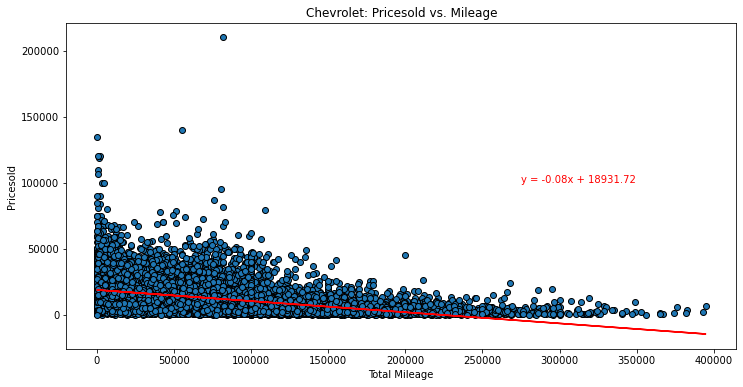

In [29]:
brand = "Chevrolet"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["Mileage"]
y = df_regression["pricesold"]
x_label = "Total Mileage"
y_label = "Pricesold"
label_regression = (275000,100000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. Mileage")

# save image
plt.savefig("Graphs-Analysis/Chevrolet-Price_vs_Mileage.png")

# display graph
plt.show()

the r-squared value is: 0.016523659724649163
the correlation between factors plotted in the graph is 0.13


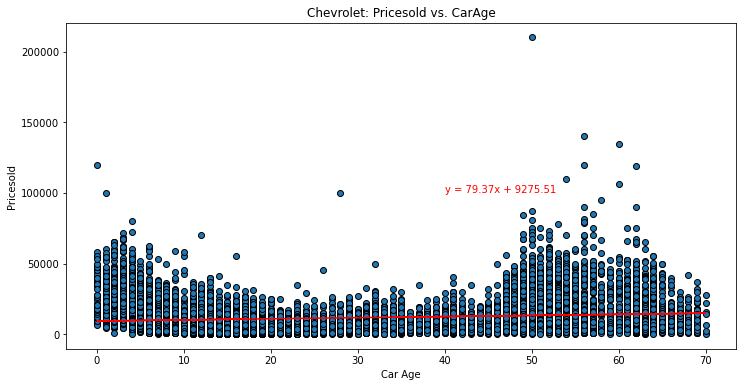

In [30]:
brand = "Chevrolet"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["CarAge"]
y = df_regression["pricesold"]
x_label = "Car Age"
y_label = "Pricesold"
label_regression = (40,100000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. CarAge")

# save image
plt.savefig("Graphs-Analysis/Chevrolet-Price_vs_Age.png")

# display graph
plt.show()

the r-squared value is: 0.2773858241968183
the correlation between factors plotted in the graph is -0.53


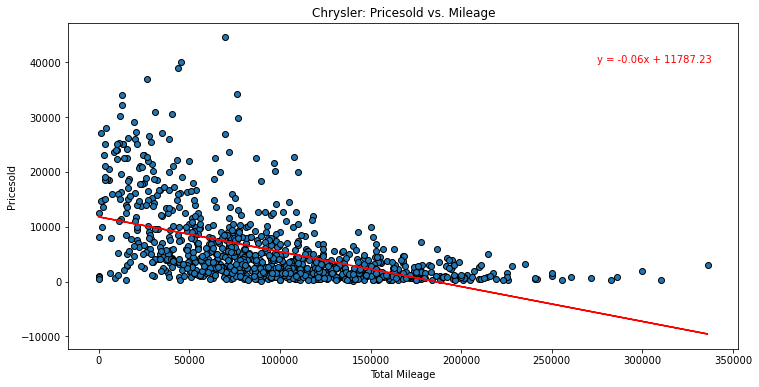

In [31]:
brand = "Chrysler"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["Mileage"]
y = df_regression["pricesold"]
x_label = "Total Mileage"
y_label = "Pricesold"
label_regression = (275000,40000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. Mileage")

# save image
plt.savefig("Graphs-Analysis/Chrysler-Price_vs_Mileage.png")

# display graph
plt.show()

the r-squared value is: 0.017613751155809258
the correlation between factors plotted in the graph is -0.13


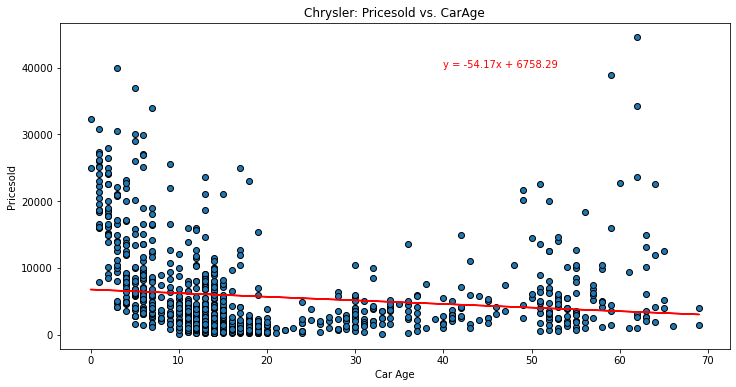

In [32]:
brand = "Chrysler"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["CarAge"]
y = df_regression["pricesold"]
x_label = "Car Age"
y_label = "Pricesold"
label_regression = (40,40000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. CarAge")

# save image
plt.savefig("Graphs-Analysis/Chrysler-Price_vs_Age.png")

# display graph
plt.show()

the r-squared value is: 0.2192801020144995
the correlation between factors plotted in the graph is -0.47


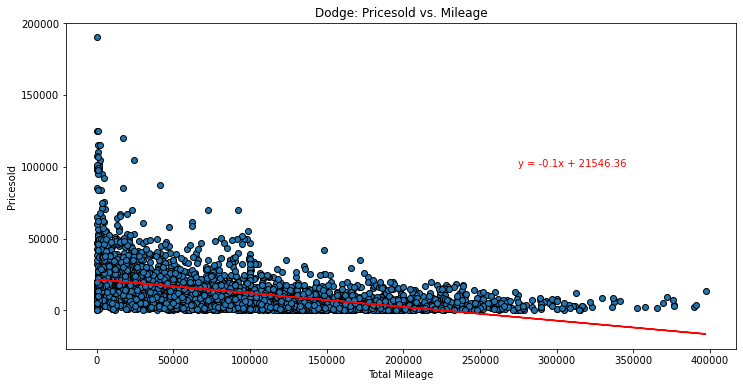

In [33]:
brand = "Dodge"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["Mileage"]
y = df_regression["pricesold"]
x_label = "Total Mileage"
y_label = "Pricesold"
label_regression = (275000,100000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. Mileage")

# save image
plt.savefig("Graphs-Analysis/Dodge-Price_vs_Mileage.png")

# display graph
plt.show()

the r-squared value is: 0.019438627313293867
the correlation between factors plotted in the graph is -0.14


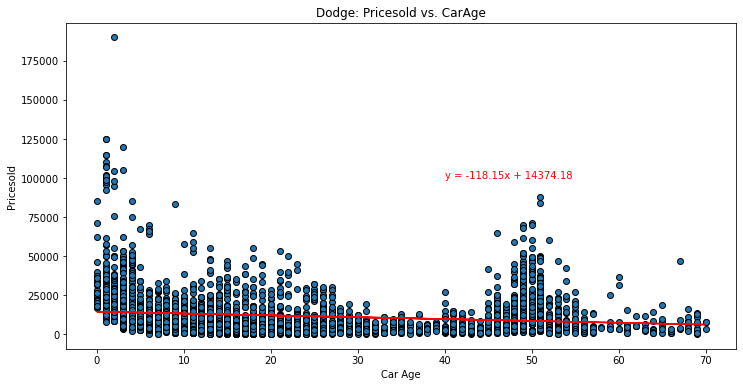

In [34]:
brand = "Dodge"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["CarAge"]
y = df_regression["pricesold"]
x_label = "Car Age"
y_label = "Pricesold"
label_regression = (40,100000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. CarAge")

# save image
plt.savefig("Graphs-Analysis/Dodge-Price_vs_Age.png")

# display graph
plt.show()

the r-squared value is: 0.1850894905201187
the correlation between factors plotted in the graph is -0.43


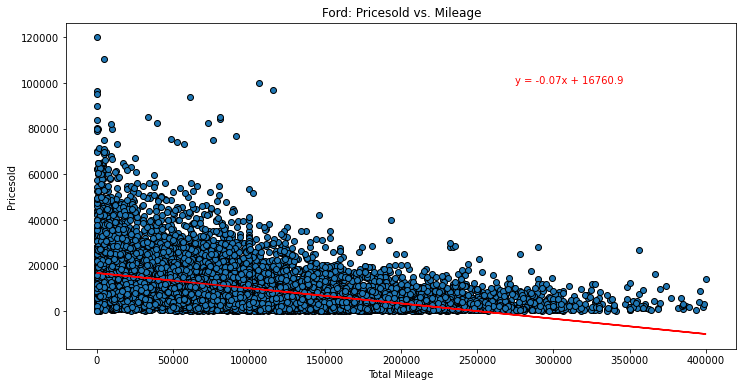

In [35]:
brand = "Ford"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["Mileage"]
y = df_regression["pricesold"]
x_label = "Total Mileage"
y_label = "Pricesold"
label_regression = (275000,100000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. Mileage")

# save image
plt.savefig("Graphs-Analysis/Ford-Price_vs_Mileage.png")

# display graph
plt.show()

the r-squared value is: 0.0012213923249739702
the correlation between factors plotted in the graph is -0.03


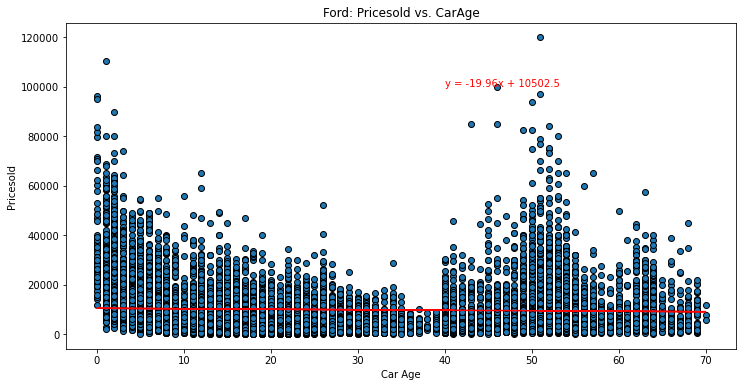

In [36]:
brand = "Ford"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["CarAge"]
y = df_regression["pricesold"]
x_label = "Car Age"
y_label = "Pricesold"
label_regression = (40,100000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. CarAge")

# save image
plt.savefig("Graphs-Analysis/Ford-Price_vs_Age.png")

# display graph
plt.show()

the r-squared value is: 0.2798148507401735
the correlation between factors plotted in the graph is -0.53


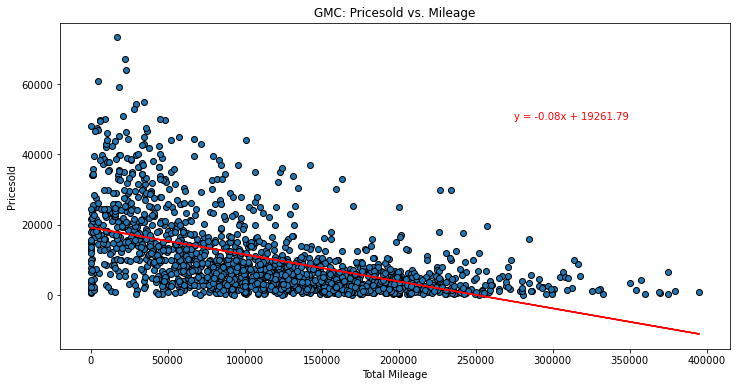

In [37]:
brand = "GMC"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["Mileage"]
y = df_regression["pricesold"]
x_label = "Total Mileage"
y_label = "Pricesold"
label_regression = (275000,50000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. Mileage")

# save image
plt.savefig("Graphs-Analysis/GMC-Price_vs_Mileage.png")

# display graph
plt.show()

the r-squared value is: 0.19437899417893997
the correlation between factors plotted in the graph is -0.44


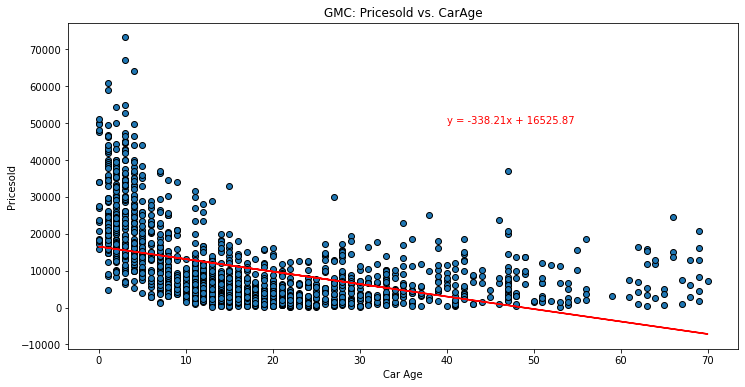

In [38]:
brand = "GMC"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["CarAge"]
y = df_regression["pricesold"]
x_label = "Car Age"
y_label = "Pricesold"
label_regression = (40,50000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. CarAge")

# save image
plt.savefig("Graphs-Analysis/GMC-Price_vs_Age.png")

# display graph
plt.show()

the r-squared value is: 0.39816448026231605
the correlation between factors plotted in the graph is -0.63


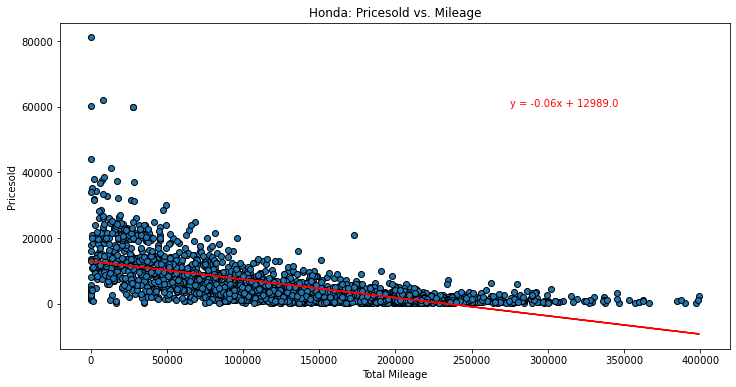

In [39]:
brand = "Honda"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["Mileage"]
y = df_regression["pricesold"]
x_label = "Total Mileage"
y_label = "Pricesold"
label_regression = (275000,60000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. Mileage")

# save image
plt.savefig("Graphs-Analysis/Honda-Price_vs_Mileage.png")

# display graph
plt.show()

the r-squared value is: 0.29530205565163287
the correlation between factors plotted in the graph is -0.54


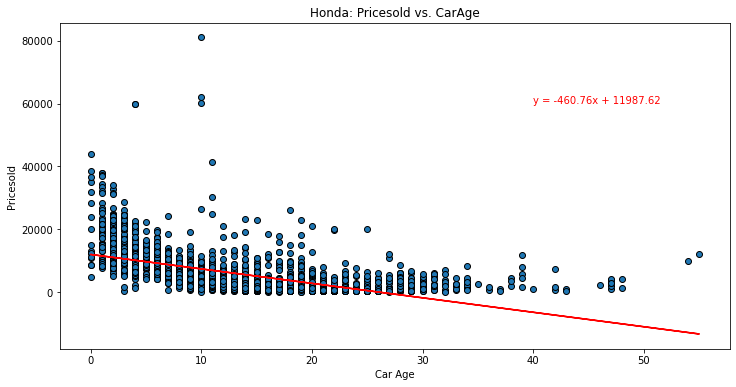

In [40]:
brand = "Honda"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["CarAge"]
y = df_regression["pricesold"]
x_label = "Car Age"
y_label = "Pricesold"
label_regression = (40,60000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. CarAge")

# save image
plt.savefig("Graphs-Analysis/Honda-Price_vs_Age.png")

# display graph
plt.show()

the r-squared value is: 0.1857343582213096
the correlation between factors plotted in the graph is -0.43


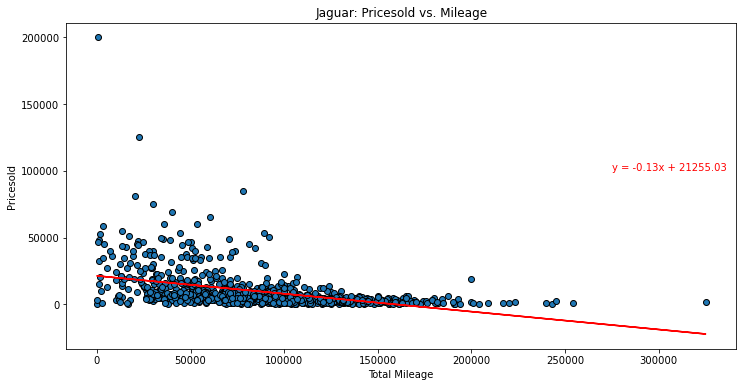

In [41]:
brand = "Jaguar"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["Mileage"]
y = df_regression["pricesold"]
x_label = "Total Mileage"
y_label = "Pricesold"
label_regression = (275000,100000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. Mileage")

# save image
plt.savefig("Graphs-Analysis/Jaguar-Price_vs_Mileage.png")

# display graph
plt.show()

the r-squared value is: 0.057848398667545375
the correlation between factors plotted in the graph is 0.24


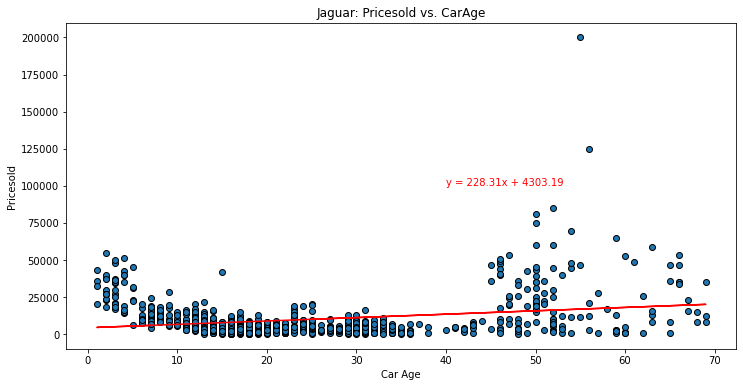

In [42]:
brand = "Jaguar"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["CarAge"]
y = df_regression["pricesold"]
x_label = "Car Age"
y_label = "Pricesold"
label_regression = (40,100000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. CarAge")

# save image
plt.savefig("Graphs-Analysis/Jaguar-Price_vs_Age.png")

# display graph
plt.show()

the r-squared value is: 0.33920029965488896
the correlation between factors plotted in the graph is -0.58


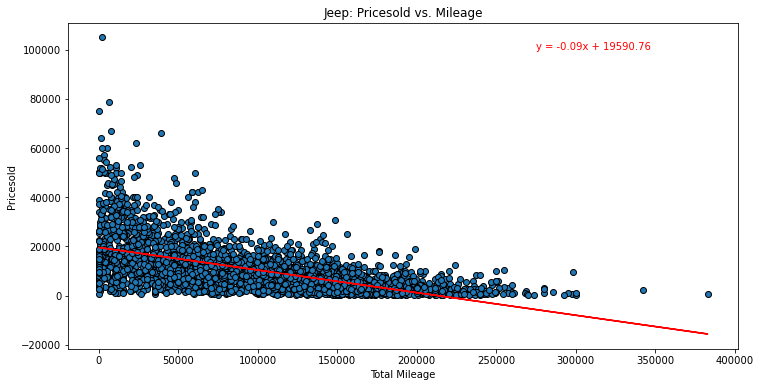

In [43]:
brand = "Jeep"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["Mileage"]
y = df_regression["pricesold"]
x_label = "Total Mileage"
y_label = "Pricesold"
label_regression = (275000,100000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. Mileage")

# save image
plt.savefig("Graphs-Analysis/Jeep-Price_vs_Mileage.png")

# display graph
plt.show()

the r-squared value is: 0.17901096788731483
the correlation between factors plotted in the graph is -0.42


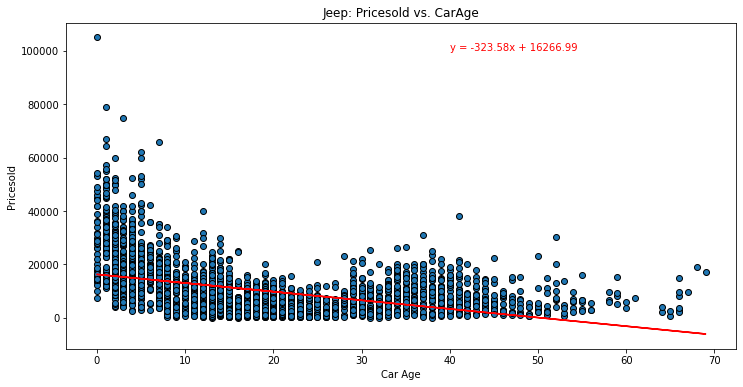

In [44]:
brand = "Jeep"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["CarAge"]
y = df_regression["pricesold"]
x_label = "Car Age"
y_label = "Pricesold"
label_regression = (40,100000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. CarAge")

# save image
plt.savefig("Graphs-Analysis/Jeep-Price_vs_Age.png")

# display graph
plt.show()

the r-squared value is: 0.2584834777126188
the correlation between factors plotted in the graph is -0.51


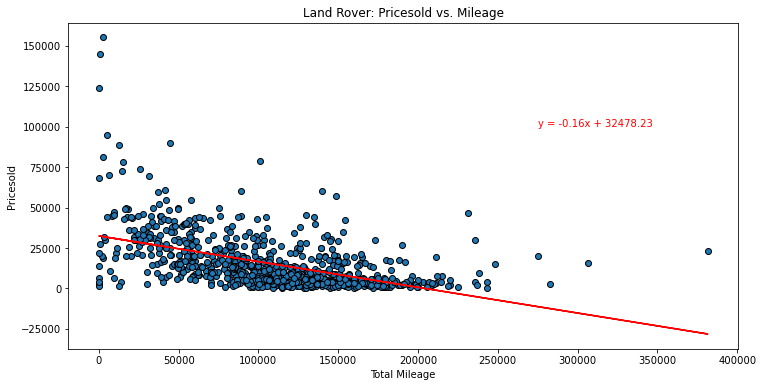

In [45]:
brand = "Land Rover"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["Mileage"]
y = df_regression["pricesold"]
x_label = "Total Mileage"
y_label = "Pricesold"
label_regression = (275000,100000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. Mileage")

# save image
plt.savefig("Graphs-Analysis/Land Rover-Price_vs_Mileage.png")

# display graph
plt.show()

the r-squared value is: 0.044747266638564015
the correlation between factors plotted in the graph is -0.21


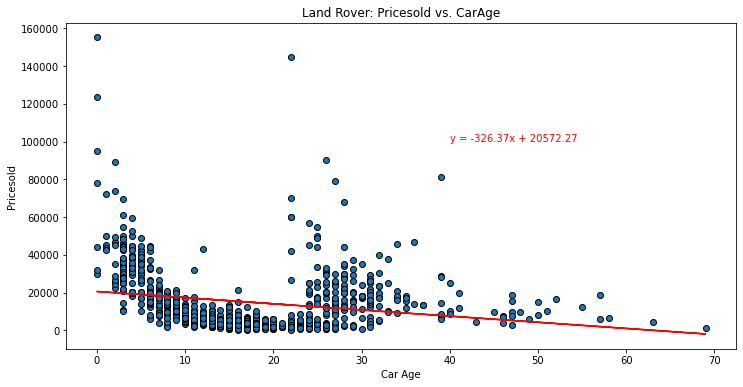

In [46]:
brand = "Land Rover"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["CarAge"]
y = df_regression["pricesold"]
x_label = "Car Age"
y_label = "Pricesold"
label_regression = (40,100000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. CarAge")

# save image
plt.savefig("Graphs-Analysis/Land Rover-Price_vs_Age.png")

# display graph
plt.show()

the r-squared value is: 0.39875394022752936
the correlation between factors plotted in the graph is -0.63


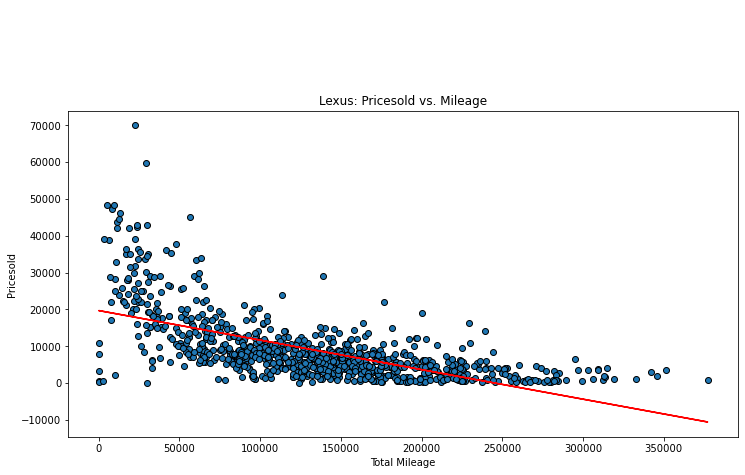

In [47]:
brand = "Lexus"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["Mileage"]
y = df_regression["pricesold"]
x_label = "Total Mileage"
y_label = "Pricesold"
label_regression = (275000,100000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. Mileage")

# save image
plt.savefig("Graphs-Analysis/Lexus-Price_vs_Mileage.png")

# display graph
plt.show()

the r-squared value is: 0.4743718059259163
the correlation between factors plotted in the graph is -0.69


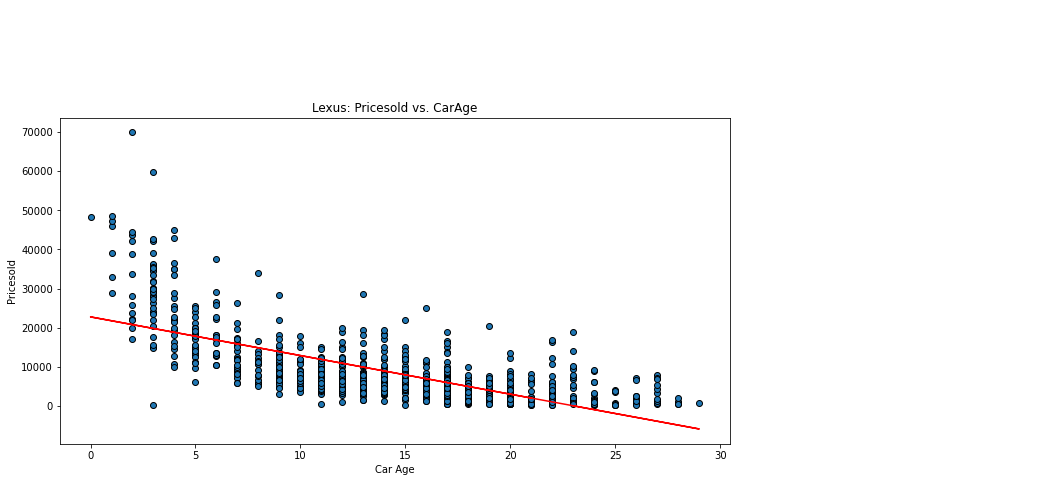

In [48]:
brand = "Lexus"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["CarAge"]
y = df_regression["pricesold"]
x_label = "Car Age"
y_label = "Pricesold"
label_regression = (40,100000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. CarAge")

# save image
plt.savefig("Graphs-Analysis/Lexus-Price_vs_Age.png")

# display graph
plt.show()

the r-squared value is: 0.2293398762503588
the correlation between factors plotted in the graph is -0.48


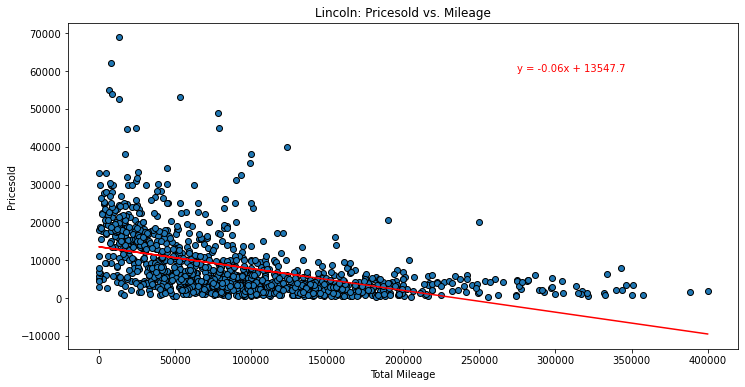

In [49]:
brand = "Lincoln"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["Mileage"]
y = df_regression["pricesold"]
x_label = "Total Mileage"
y_label = "Pricesold"
label_regression = (275000,60000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. Mileage")

# save image
plt.savefig("Graphs-Analysis/Lincoln-Price_vs_Mileage.png")

# display graph
plt.show()

the r-squared value is: 0.025672929801392963
the correlation between factors plotted in the graph is -0.16


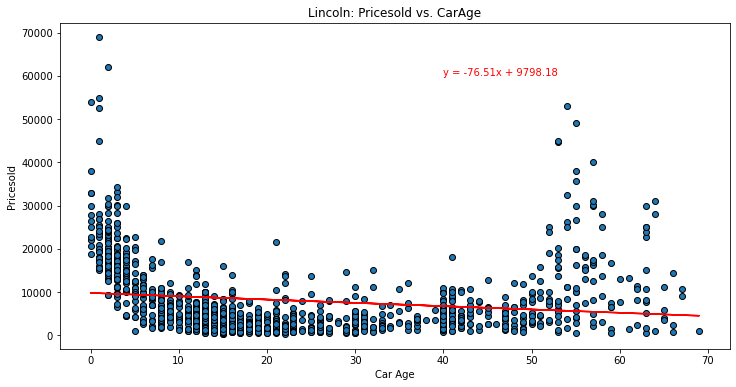

In [50]:
brand = "Lincoln"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["CarAge"]
y = df_regression["pricesold"]
x_label = "Car Age"
y_label = "Pricesold"
label_regression = (40,60000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. CarAge")

# save image
plt.savefig("Graphs-Analysis/Lincoln-Price_vs_Age.png")

# display graph
plt.show()

the r-squared value is: 0.1889297033093408
the correlation between factors plotted in the graph is -0.43


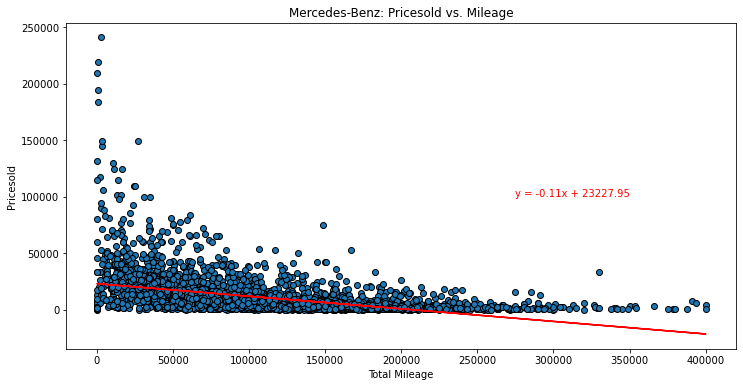

In [51]:
brand = "Mercedes-Benz"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["Mileage"]
y = df_regression["pricesold"]
x_label = "Total Mileage"
y_label = "Pricesold"
label_regression = (275000,100000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. Mileage")

# save image
plt.savefig("Graphs-Analysis/Mercedes-Benz-Price_vs_Mileage.png")

# display graph
plt.show()

the r-squared value is: 0.047908790222682365
the correlation between factors plotted in the graph is -0.22


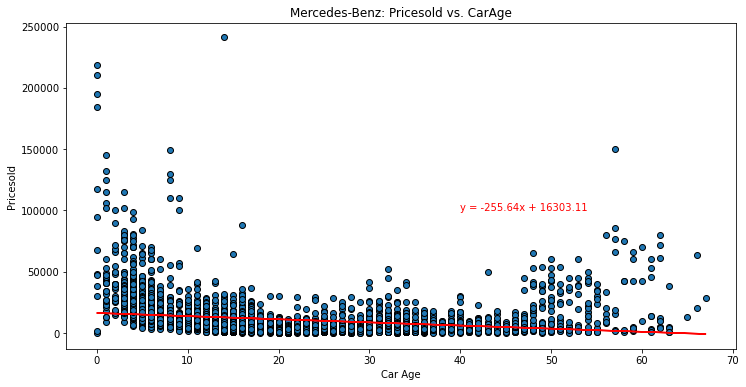

In [52]:
brand = "Mercedes-Benz"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["CarAge"]
y = df_regression["pricesold"]
x_label = "Car Age"
y_label = "Pricesold"
label_regression = (40,100000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. CarAge")

# save image
plt.savefig("Graphs-Analysis/Mercedes-Benz-Price_vs_Age.png")

# display graph
plt.show()

the r-squared value is: 0.24801524269633382
the correlation between factors plotted in the graph is -0.5


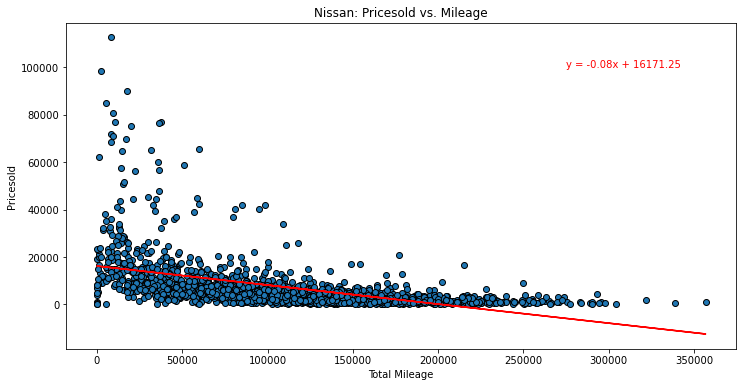

In [53]:
brand = "Nissan"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["Mileage"]
y = df_regression["pricesold"]
x_label = "Total Mileage"
y_label = "Pricesold"
label_regression = (275000,100000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. Mileage")

# save image
plt.savefig("Graphs-Analysis/Nissan-Price_vs_Mileage.png")

# display graph
plt.show()

the r-squared value is: 0.07387586677167045
the correlation between factors plotted in the graph is -0.27


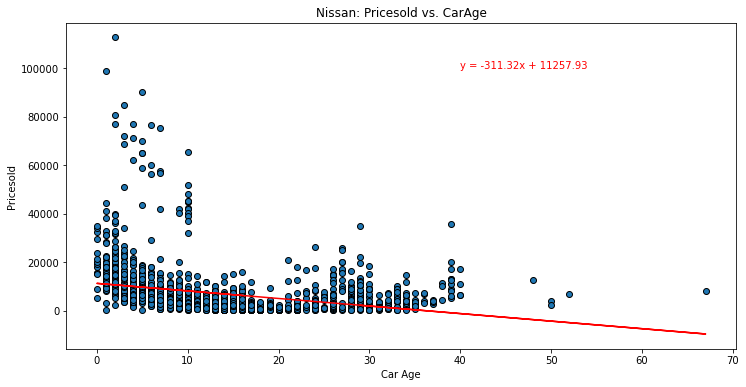

In [54]:
brand = "Nissan"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["CarAge"]
y = df_regression["pricesold"]
x_label = "Car Age"
y_label = "Pricesold"
label_regression = (40,100000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. CarAge")

# save image
plt.savefig("Graphs-Analysis/Nissan-Price_vs_Age.png")

# display graph
plt.show()

the r-squared value is: 0.17455559566117823
the correlation between factors plotted in the graph is -0.42


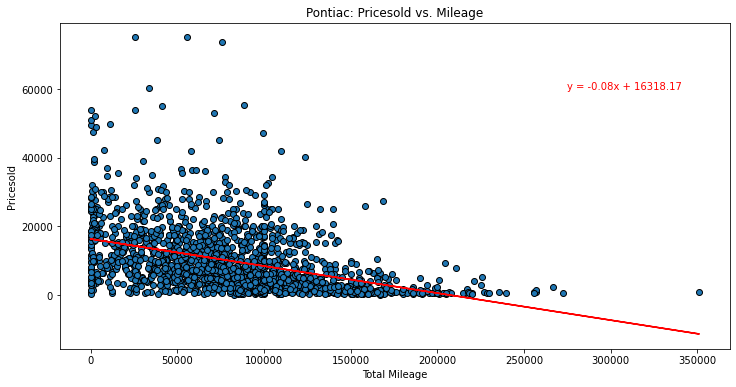

In [55]:
brand = "Pontiac"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["Mileage"]
y = df_regression["pricesold"]
x_label = "Total Mileage"
y_label = "Pricesold"
label_regression = (275000,60000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. Mileage")

# save image
plt.savefig("Graphs-Analysis/Pontiac-Price_vs_Mileage.png")

# display graph
plt.show()

the r-squared value is: 0.12986778859278453
the correlation between factors plotted in the graph is 0.36


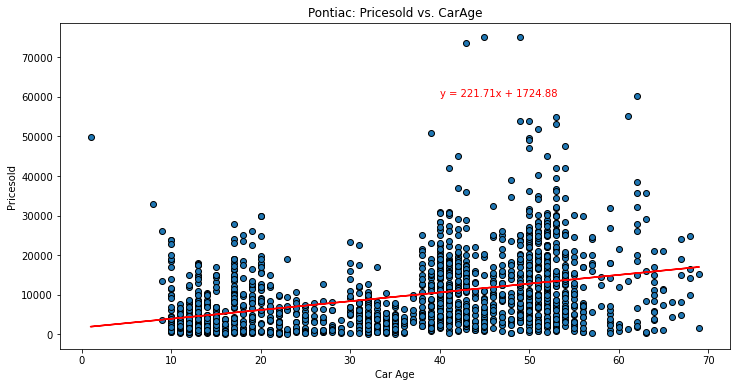

In [56]:
brand = "Pontiac"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["CarAge"]
y = df_regression["pricesold"]
x_label = "Car Age"
y_label = "Pricesold"
label_regression = (40,60000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. CarAge")

# save image
plt.savefig("Graphs-Analysis/Pontiac-Price_vs_Age.png")

# display graph
plt.show()

the r-squared value is: 0.17811244626482117
the correlation between factors plotted in the graph is -0.42


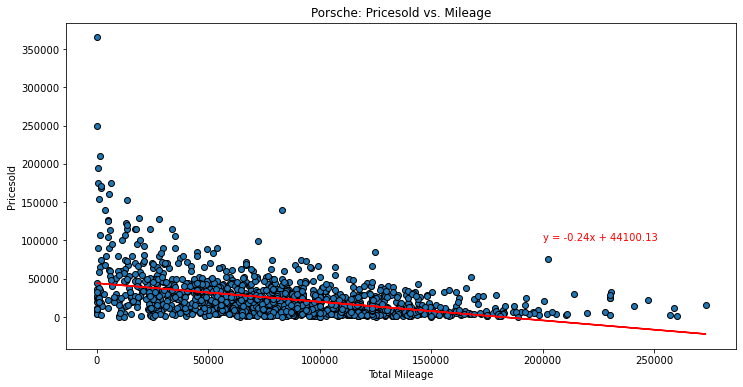

In [57]:
brand = "Porsche"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["Mileage"]
y = df_regression["pricesold"]
x_label = "Total Mileage"
y_label = "Pricesold"
label_regression = (200000,100000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. Mileage")

# save image
plt.savefig("Graphs-Analysis/Porsche-Price_vs_Mileage.png")

# display graph
plt.show()

the r-squared value is: 0.053619727789031506
the correlation between factors plotted in the graph is -0.23


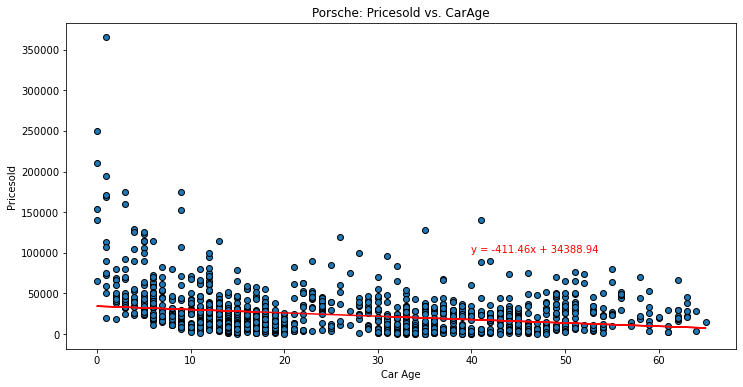

In [58]:
brand = "Porsche"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["CarAge"]
y = df_regression["pricesold"]
x_label = "Car Age"
y_label = "Pricesold"
label_regression = (40,100000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. CarAge")

# save image
plt.savefig("Graphs-Analysis/Porsche-Price_vs_Age.png")

# display graph
plt.show()

the r-squared value is: 0.38892725942769196
the correlation between factors plotted in the graph is -0.62


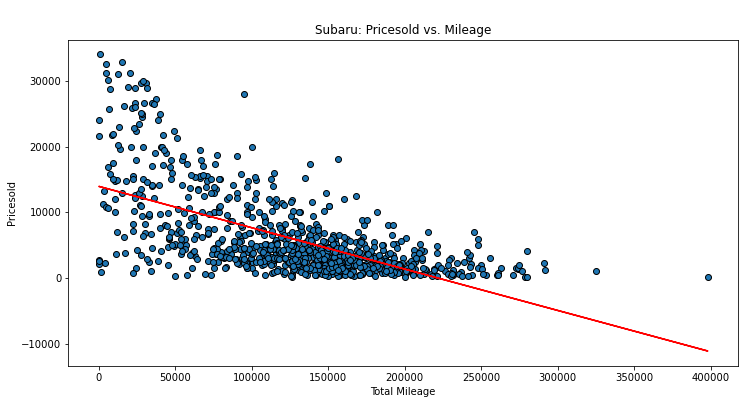

In [59]:
brand = "Subaru"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["Mileage"]
y = df_regression["pricesold"]
x_label = "Total Mileage"
y_label = "Pricesold"
label_regression = (275000,40000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. Mileage")

# save image
plt.savefig("Graphs-Analysis/Subaru-Price_vs_Mileage.png")

# display graph
plt.show()

the r-squared value is: 0.22313785107792697
the correlation between factors plotted in the graph is -0.47


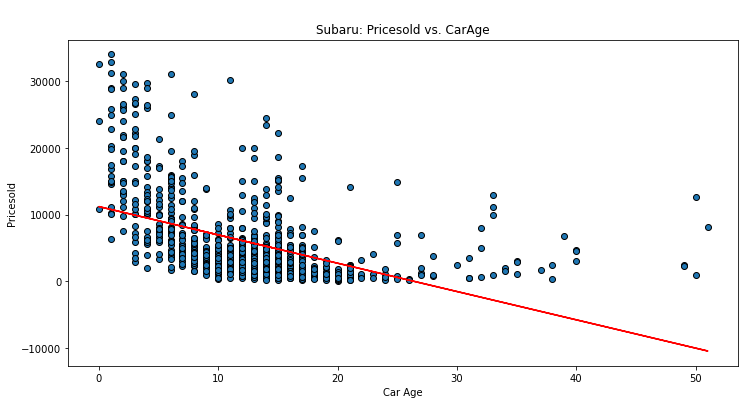

In [60]:
brand = "Subaru"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["CarAge"]
y = df_regression["pricesold"]
x_label = "Car Age"
y_label = "Pricesold"
label_regression = (40,40000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. CarAge")

# save image
plt.savefig("Graphs-Analysis/Subaru-Price_vs_Age.png")

# display graph
plt.show()

the r-squared value is: 0.30433913316797995
the correlation between factors plotted in the graph is -0.55


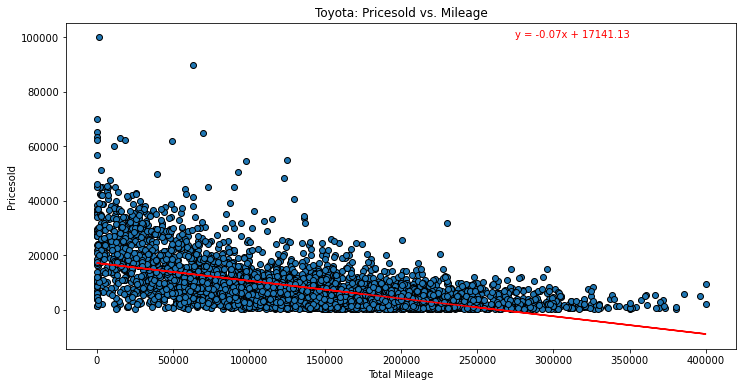

In [61]:
brand = "Toyota"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["Mileage"]
y = df_regression["pricesold"]
x_label = "Total Mileage"
y_label = "Pricesold"
label_regression = (275000,100000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. Mileage")

# save image
plt.savefig("Graphs-Analysis/Toyota-Price_vs_Mileage.png")

# display graph
plt.show()

the r-squared value is: 0.047464624415530336
the correlation between factors plotted in the graph is -0.22


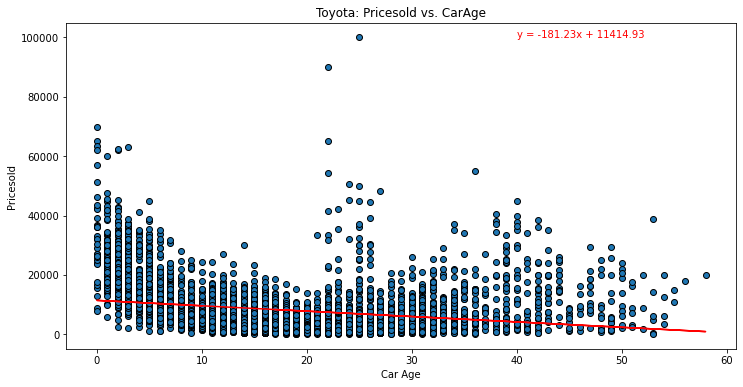

In [62]:
brand = "Toyota"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["CarAge"]
y = df_regression["pricesold"]
x_label = "Car Age"
y_label = "Pricesold"
label_regression = (40,100000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. CarAge")

# save image
plt.savefig("Graphs-Analysis/Toyota-Price_vs_Age.png")

# display graph
plt.show()

the r-squared value is: 0.11488004715835294
the correlation between factors plotted in the graph is -0.34


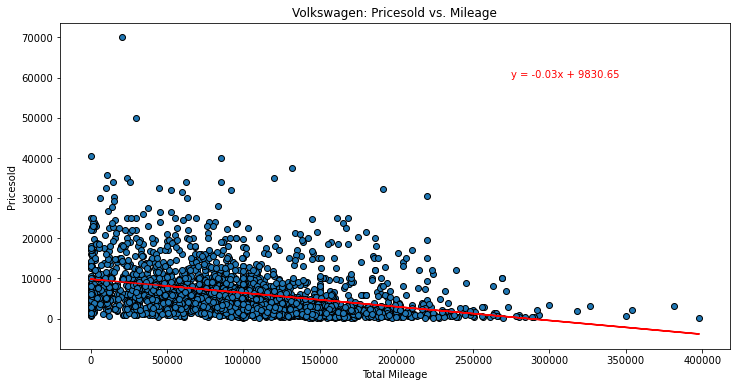

In [63]:
brand = "Volkswagen"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["Mileage"]
y = df_regression["pricesold"]
x_label = "Total Mileage"
y_label = "Pricesold"
label_regression = (275000,60000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. Mileage")

# save image
plt.savefig("Graphs-Analysis/Volkswagen-Price_vs_Mileage.png")

# display graph
plt.show()

the r-squared value is: 0.036435222946267574
the correlation between factors plotted in the graph is 0.19


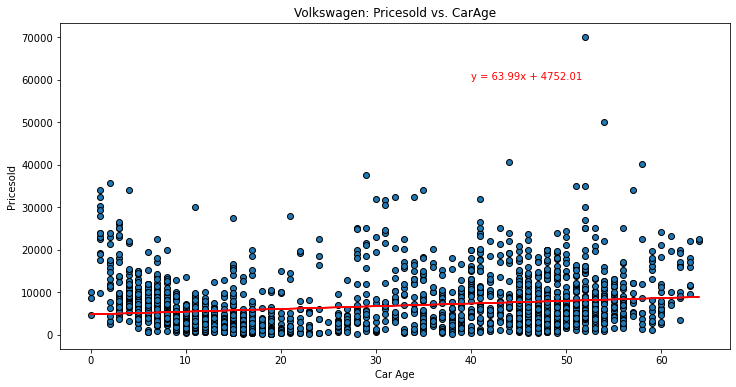

In [64]:
brand = "Volkswagen"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["CarAge"]
y = df_regression["pricesold"]
x_label = "Car Age"
y_label = "Pricesold"
label_regression = (40,60000)

# call function
plot_lin_regress(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. CarAge")

# save image
plt.savefig("Graphs-Analysis/Volkswagen-Price_vs_Age.png")

# display graph
plt.show()

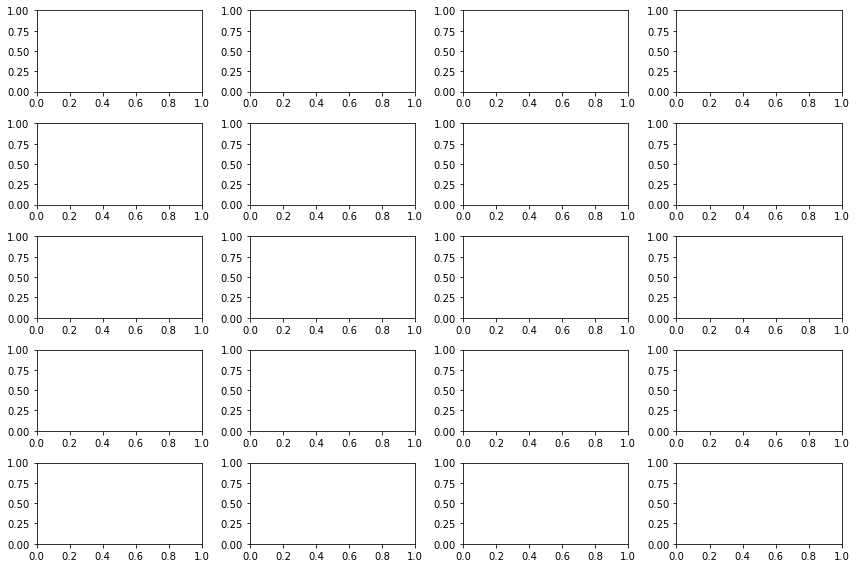

In [75]:
fig, ax = plt.subplots(5,4, figsize = (12,8))
fig.tight_layout(pad = 1.0)
plt.show()

In [76]:
# fig = plt.figure()
# fig.set_figheight(8)
# fig.set_figwidth(12)
 

# ax1 = plt.subplot2grid(shape=(5,5), loc=(0, 0))
# ax2 = plt.subplot2grid((5, 5), (0, 1))
# ax3 = plt.subplot2grid((5, 5), (0, 2))
# ax4 = plt.subplot2grid((5, 5), (0, 3))
# ax5 = plt.subplot2grid((5, 5), (0, 4))
# ax6 = plt.subplot2grid((5, 5), (1, 0))
# ax7 = plt.subplot2grid((5, 5), (1, 1))
# ax8 = plt.subplot2grid((5, 5), (1, 2))
# ax9 = plt.subplot2grid((5, 5), (1, 3))
# ax10 = plt.subplot2grid((5, 5), (1,4))

# fig.tight_layout(pad = 2.0)
# plt.show()

In [67]:
# create distinct list of car models (to use for box, whisker -- for loop)
car_makes = list(df_analysis_filtered["Make"].unique())
car_makes = sorted(car_makes)

# create an empty list to fill with prices sold for each car make
salesprices = []

# use for loop to loop through price sold - determine outliers
for make in car_makes:
    
    #loop through list of cars and filter where car make matches car in for loop
    df_analysis_by_make = df_analysis_filtered.loc[df_analysis_filtered["Make"] == make]
    
    # calculate the number of cars by Make
    cars_per_make = df_analysis_by_make["Make"].count()

    #create dataframe containing car price
    df_price = df_analysis_by_make[["pricesold"]]
    
    #create a series with the sale price & add to list for that car brand/make
    saleprice = df_price["pricesold"]
    salesprices.append(saleprice)
    
    #calculate each car make's IQR for price
    quartiles = saleprice.quantile([.25, .5, .75])
    quartile_1 = quartiles[.25]
    quartile_3 = quartiles[.75]
    iqr = quartile_3 - quartile_1

    # display IQR for sale price of each car
    print(f"There are {cars_per_make} cars included in the saleprice recap for {make}: ")
    print(f" The IQR for the price sold is ${iqr}")
    
    # calculate the bounds
    bound_lower = quartile_1 - (1.5*iqr)
    bound_upper = quartile_3 + (1.5*iqr)
    
    # display the bounds for each car make
    print(f" The lower bound is: ${bound_lower}, the upper bound is: ${bound_upper}")
    
    #check for outliers in each car make
    count_outliers = saleprice.loc[(df_price["pricesold"] >= bound_upper) | 
                                      (df_price["pricesold"] <= bound_lower)].count()

    prct_outlier = (count_outliers / cars_per_make) * 100
    prct_outlier = str(round(prct_outlier,3))
    
    print(f" There are {count_outliers} cars that could be viewed as outliers or {prct_outlier}%\n")
    

There are 1027 cars included in the saleprice recap for Audi: 
 The IQR for the price sold is $9710.0
 The lower bound is: $-11665.0, the upper bound is: $27175.0
 There are 93 cars that could be viewed as outliers or 9.056%

There are 3535 cars included in the saleprice recap for BMW: 
 The IQR for the price sold is $8315.0
 The lower bound is: $-9472.5, the upper bound is: $23787.5
 There are 290 cars that could be viewed as outliers or 8.204%

There are 1104 cars included in the saleprice recap for Buick: 
 The IQR for the price sold is $10425.0
 The lower bound is: $-13537.5, the upper bound is: $28162.5
 There are 30 cars that could be viewed as outliers or 2.717%

There are 2394 cars included in the saleprice recap for Cadillac: 
 The IQR for the price sold is $11100.0
 The lower bound is: $-13650.0, the upper bound is: $30750.0
 There are 130 cars that could be viewed as outliers or 5.43%

There are 12734 cars included in the saleprice recap for Chevrolet: 
 The IQR for the pric

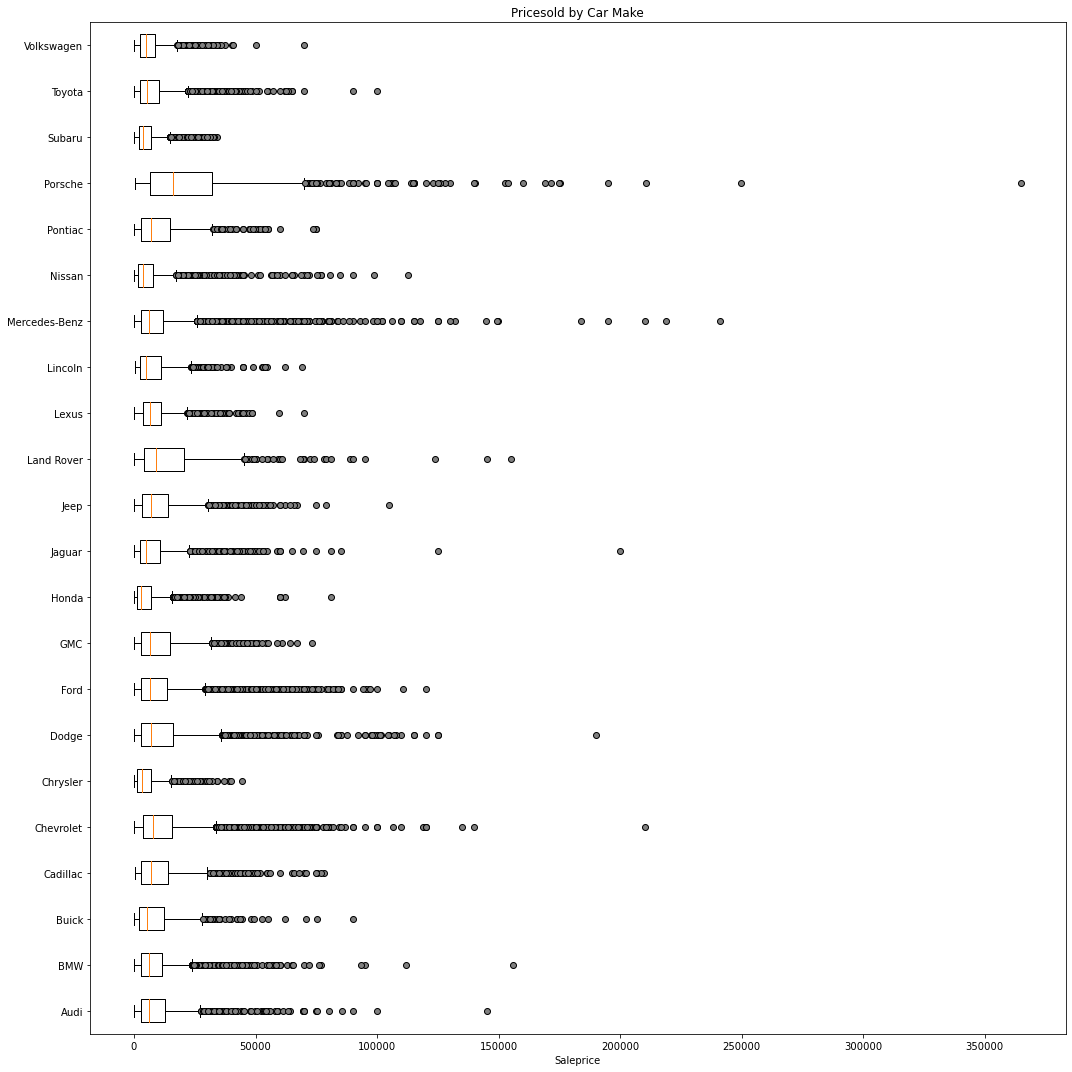

In [68]:
flierprops = dict(marker = 'o', markerfacecolor = 'gray', markeredgecolor = "black")

plt.rcParams["figure.figsize"] = [15, 15]
plt.rcParams["figure.autolayout"] = True

plt.boxplot(salesprices, vert=False, labels = car_makes, flierprops = flierprops)

plt.title("Pricesold by Car Make")
plt.xlabel("Saleprice")
plt.show()

In [69]:
# calculate the total $ sold by make
price_make = df_analysis_filtered.groupby(["Make"]).sum()["pricesold"]
price_make

Make
Audi              10980700
BMW               32903370
Buick              9388240
Cadillac          24776210
Chevrolet        149102100
Chrysler           5611500
Dodge             43904340
Ford             131412720
GMC               17423770
Honda             13118440
Jaguar             8229610
Jeep              31007960
Land Rover        12267030
Lexus              8012330
Lincoln           10079520
Mercedes-Benz     44469750
Nissan            11524330
Pontiac           16095290
Porsche           34263830
Subaru             5417490
Toyota            36145030
Volkswagen        15114200
Name: pricesold, dtype: int64

In [70]:
# calculate the number of cars by Make
cars_per_make = df_analysis_filtered["Make"].value_counts()
cars_per_make

Ford             13139
Chevrolet        12734
Toyota            4401
Mercedes-Benz     4121
Dodge             3699
BMW               3535
Jeep              3014
Cadillac          2394
Honda             2361
Volkswagen        2316
Nissan            1647
GMC               1644
Pontiac           1635
Porsche           1436
Lincoln           1236
Buick             1104
Audi              1027
Chrysler           986
Subaru             915
Lexus              894
Jaguar             835
Land Rover         810
Name: Make, dtype: int64

In [71]:
# calculate the average price by car make
avg_price_make = df_analysis_filtered.groupby(["Make"]).mean()["pricesold"]
avg_price_make

Make
Audi             10692.015579
BMW               9307.884017
Buick             8503.840580
Cadillac         10349.294069
Chevrolet        11708.975970
Chrysler          5691.176471
Dodge            11869.245742
Ford             10001.729203
GMC              10598.400243
Honda             5556.306650
Jaguar            9855.820359
Jeep             10287.976111
Land Rover       15144.481481
Lexus             8962.337808
Lincoln           8154.951456
Mercedes-Benz    10791.009464
Nissan            6997.164542
Pontiac           9844.214067
Porsche          23860.605850
Subaru            5920.754098
Toyota            8212.912974
Volkswagen        6525.993092
Name: pricesold, dtype: float64

In [72]:
# calculate the average price by car make_model
avg_price_make_model = df_analysis_filtered.groupby(["Make","Model"]).mean()["pricesold"]
avg_price_make_model

Make        Model                
Audi        100                       2106.666667
            200                       1730.000000
            200 20V                   1840.000000
            200 Quattro              12100.000000
            4000 Quattro              3000.000000
                                         ...     
Volkswagen  Type III                  6938.000000
            Vanagon                   5525.000000
            Volkswagon Dune Buggy     5700.000000
            dune buggy                5380.000000
            jetta                     1010.000000
Name: pricesold, Length: 1464, dtype: float64

In [73]:
# calculate the number of cars by car make_model
number_make_model = df_analysis_filtered.groupby(["Make","Model"]).count()["ID"]
number_make_model

Make        Model                
Audi        100                      6
            200                      1
            200 20V                  1
            200 Quattro              1
            4000 Quattro             1
                                    ..
Volkswagen  Type III                 5
            Vanagon                  2
            Volkswagon Dune Buggy    1
            dune buggy               1
            jetta                    1
Name: ID, Length: 1464, dtype: int64